In [ ]:
import pandas as pd

## Data preparation

In [ ]:
# data source: https://surfdrive.surf.nl/files/index.php/s/CZWfWQp3VKGKa8m
df = pd.read_csv('data_with_ports.csv.gz', sep='|', compression='gzip')

In [ ]:
# parse string to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S+09:00')
df['stop_time'] = pd.to_datetime(df['stop_time'], format='%Y-%m-%dT%H:%M:%S+09:00')

In [ ]:
# remove reserved ips
reserved_ips = [
    "0.",       # software
    "10.",      # private network
    "100.",     # private network
    "169.254.", # subnet
    "172.",     # private network
    "192."      # private network
]

df = df[~(df.org.isna() & df.target_ip.str.startswith(tuple(reserved_ips)))]

In [ ]:
# subset victim data of hosting providers
hp = df.loc[df.as_type == "hosting"]

In [ ]:
from random import randint

hp.iloc[randint(0, len(hp))]

In [ ]:
# fix NaNs in `regions` data for victims that reside in United States and Canada
hp.loc[hp.raw_country.str.contains("United States|Cananda"), "region"] = "NA" # NA = North America

In [ ]:
# victim org         = org
# size of victims    = org_ipsize_seen
# type of victim     = org_tag
# country victim     = raw_country
# network hygiene    = count_attacks_2014
# dependent variable = count_attacks

orgs = (hp.groupby(by=["org", "org_ipsize_seen", "org_tag", "raw_country", "region", "year"])
          .size().unstack().add_prefix("count_attack_")
          .fillna(0))

orgs.reset_index(inplace=True)
orgs.columns = orgs.columns.tolist()

orgs["count_attack"] = orgs.filter(regex="^count_attack").sum(axis=1)
orgs["count_attack_norm"] = orgs.count_attack / orgs.org_ipsize_seen

orgs.raw_country = orgs.raw_country.apply(lambda s: s.replace("<comma>", ","))

# remove companies that received just 1 attack, as we assume the first attack was only a trial
orgs = orgs[orgs.count_attack > 1]

#### ITU ICT index

In [ ]:
# https://tcdata360.worldbank.org/indicators/h2e1ddd20
itu_index = pd.read_csv("ITU-ICT-index.csv")

# fix naming mismatch for "Slovakia" and "Korea, Republic of"
itu_index.loc[itu_index.Country.str.contains("Korea"), "Country"] = "Korea, Republic of"
itu_index.loc[itu_index.Country.str.contains("Slovak"), "Country"] = "Slovakia"

orgs = pd.merge(orgs, itu_index, how="left", 
                left_on="raw_country", right_on="Country").drop(columns=["Country"])

#### Export data

In [ ]:
orgs.to_csv("orgs.csv")

In [ ]:
orgs

## Visualisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
orgs = pd.read_csv("orgs.csv")

In [3]:
orgs.head()

,Unnamed: 0,org,org_ipsize_seen,org_tag,raw_country,region,count_attack_2014,count_attack_2015,count_attack,count_attack_norm,ITU-ICT
0,0,1&1 Internet,73813.0,hosting,Germany,WE,0.0,4.0,4.0,0.000054,8.1
1,1,1&1 Internet,73813.0,hosting,United States,NaN,189.0,634.0,823.0,0.011150,8.1
2,2,1&1 Internet AG,181901.0,hosting,Germany,WE,539.0,2135.0,2674.0,0.014700,8.1
3,3,104319 Jays Webworks,5.0,hosting,United States,NaN,2.0,0.0,2.0,0.400000,8.1
4,4,10Hosting,109.0,hosting,United States,NaN,0.0,413.0,413.0,3.788991,8.1


#### Per IP size

Most companies have their `org_ipsize_seen` < threshold with few "outliers" having very large `org_ipsize_seen`. This is illustrated with the very narrow whisker ends and far-away flier points in the boxplot.

In [4]:
THRESHOLD = 3e5

count    8.610000e+02
mean     1.089447e+04
std      7.864855e+04
min      1.000000e+00
25%      1.400000e+01
50%      9.100000e+01
75%      1.178000e+03
max      1.567292e+06
Name: org_ipsize_seen, dtype: float64

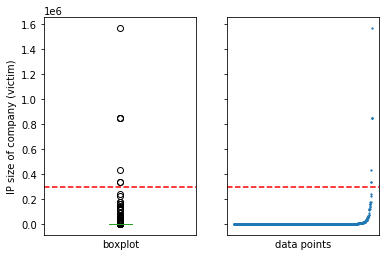

In [5]:
fig, ax = plt.subplots(1, 2, sharey=True)

org_ipsize_seen_sorted = orgs.org_ipsize_seen.sort_values().reset_index(drop=True).reset_index()

orgs.org_ipsize_seen.plot.box(ax=ax[0])
org_ipsize_seen_sorted.plot.scatter(x="index", y="org_ipsize_seen", ax=ax[1], s=1.5)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].set_xticks([]), ax[1].set_xticks([])
ax[0].set_ylabel("IP size of company (victim)")
ax[0].set_xlabel("boxplot"), ax[1].set_xlabel("data points")

# draw a threshold
ax[0].axhline(y=THRESHOLD, color='r', linestyle="--")
ax[1].axhline(y=THRESHOLD, color='r', linestyle="--")

# print statistics
orgs.org_ipsize_seen.describe()

In [6]:
# the big hosting providers (`org_ipsize_seen` > THRESHOLD)
orgs.loc[orgs.org_ipsize_seen > THRESHOLD]

,Unnamed: 0,org,org_ipsize_seen,org_tag,raw_country,region,count_attack_2014,count_attack_2015,count_attack,count_attack_norm,ITU-ICT
36,36,"Akamai International, BV",430031.0,cdn,United States,NaN,0.0,35.0,35.0,0.000081,8.1
37,37,Akamai Technologies,1567292.0,cdn,United States,NaN,238.0,883.0,1121.0,0.000715,8.1
46,46,Amazon.com,844486.0,hosting,United States,NaN,2588.0,8452.0,11040.0,0.013073,8.1
47,47,Amazon.com,844486.0,hosting,Australia,AP,74.0,235.0,309.0,0.000366,8.2
48,48,Amazon.com,844486.0,hosting,Ireland,WE,495.0,1667.0,2162.0,0.002560,7.7
496,496,OVH SAS,337625.0,hosting,France,WE,35171.0,105993.0,141164.0,0.418109,8.0
497,497,OVH SAS,337625.0,hosting,Portugal,WE,0.0,8.0,8.0,0.000024,6.6


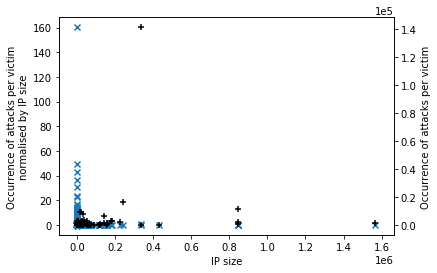

In [7]:
fig, ax1 = plt.subplots()
ax1.scatter(x=orgs.org_ipsize_seen, y=orgs.count_attack_norm,  marker="x")
ax1.set_ylabel("Occurrence of attacks per victim\nnormalised by IP size"), ax1.set_xlabel("IP size")
# ax1.axvline(x=THRESHOLD, color='r', linestyle="--")

ax2 = ax1.twinx()
ax2.scatter(x=orgs.org_ipsize_seen, y=orgs.count_attack, marker="+", color="black")
ax2.set_ylabel("Occurrence of attacks per victim")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
fig.savefig("images/attack-by-ipsize.png")

#### Per Country

In [ ]:
# color the boxplots per region
regions = orgs.region.unique()
raw_countries = orgs.sort_values(by=["region", "raw_country"]).raw_country.unique()
colors = {regions[i] : sns.color_palette(n_colors=len(regions))[i] for i in range(len(regions))}

# repalce abbrs with fullname
regions_f = ["Western Europe",   # WE
             "North America",    # NA
             "Asian Pacific",    # AP
             "Eastern Europe",   # EE
             "Latin America",    # LC
             "Middle East",      # ME
             "Africa" ]          # AF

In [ ]:
import matplotlib.patches as mpatches

# plot per country
fig, ax = plt.subplots(len(raw_countries), figsize=(8,12), sharex=True)

for i in range(len(raw_countries)):
    region = orgs.region[orgs.raw_country == raw_countries[i]].values[0]
    sns.boxplot(x="count_attack", y="raw_country", orient="h", color=colors[region],
                data=orgs.sort_values(by=["region", "raw_country"]).loc[orgs.raw_country == raw_countries[i]], ax=ax[i])  
    
    # formatting axis
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].tick_params(axis='both', which='both', length=0)
    
ax[i].set(xscale="log")
ax[0].spines["top"].set_visible(True)
ax[i].spines["bottom"].set_visible(True)
ax[i].set_xlabel("Occurrence of attack against victims")
plt.legend(handles=[mpatches.Patch(color=colors[regions[i]], label=regions_f[i]) 
                    for i in range(len(regions))], bbox_to_anchor=(1., 1.2*len(raw_countries)),
          title="Region")

fig.savefig("images/attack-by-country.png")

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x=orgs.org_ipsize_seen, y=orgs.count_attack_norm)
ax.set_xlabel("IP size of victim")
ax.set_ylabel("Occurrence of attacks \nnormalised by IP size")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.savefig("images/normalised-attacks.png")